## Homework Set 5 - Connor Johnson

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.misc import derivative
from scipy.signal import argrelextrema
import sympy as sp
import fractions as fra
import math
from math import exp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'png'
from matplotlib import pyplot as plt

from itertools import product

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix'
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Math, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

In [2]:
# Phase portrait: streamplot
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax   

# Display fixed points
def PP_FPs(FPs,tau,delta,ax, print_stable = False):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            if print_stable:
                print('stable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            if print_stable:
                print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,title='',x_lab='$r$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)
    fig, ax=plt.subplots()
    ax.contour(R,X,Zs,levels=[0],colors='k',linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors='k',linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel('$x^\star$')
    ax.set_title(title,color='b')
    plt.show()   

### Problem 1

#### Part (a)

Dynamical System:<br>
$x_1=\phi , \dot{x_1}=\frac{d\phi}{d\tau}$<br>
$x_2=\dot{x_1}, \dot{x_2} = \frac{1}{\epsilon}(-x_2-sin(x_1)+\gamma sin(x_1)cos(x_1))$

In [3]:
# define f1, f2 and A
x,y,g,e = sp.symbols(r'x,y,\gamma,\epsilon',nonnegative=True)

f1 = lambda y: y
f2 = lambda x,y,g,e: (1/e)*(-y+sp.sin(x)*(-1+g*sp.cos(x)))

A = lambda x,y,g,e: sp.Matrix([f1(y),f2(x,y,g,e)]).jacobian([x,y]).applyfunc(sp.factor)
display(Latex(r'Jacobian of the Linearized System: ${}$'.format(sp.latex(A(x,y,g,e)))))
tau = A(x,y,g,e).trace()
delta = A(x,y,g,e).det()
display(Latex(r'$\tau={}$'.format(sp.latex(sp.simplify(tau)))))
display(Latex('$\Delta={}$'.format(sp.latex(sp.simplify(delta)))))
display(Latex(r'$\tau^2-4\Delta={}$'.format(
    sp.latex(sp.simplify(sp.Add(sp.Mul(tau,tau), sp.Mul(sp.Integer(-4), delta)))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
# calculate fixed points (FPs) and their attributes

FPs = sp.solve((f1(y),f2(x,y,g,e)),x,y)

FPs_ = [[FP_i.subs({x:x,y:y}) for FP_i in FP] for FP in FPs]
A_FPs_ = [A(x,y,g,e).subs({x:FP[0],y:FP[1]}) for FP in FPs_]
tau_   = [A_FP.trace() for A_FP in A_FPs_]
delta_ = [A_FP.det() for A_FP in A_FPs_]

print('Fixed Points with Trace, Determinant, and Discriminant Calculations:')
[display(Latex('${}$ -> Trace: ${}$, Determinant: ${}$, Discriminant: ${}$'.
               format(sp.latex(FP),
                      sp.latex(t),
                      sp.latex(d),
                      sp.latex(sp.simplify(sp.Add(sp.Mul(t,t), sp.Mul(sp.Integer(-4), d)))))))
                      for FP,t,d in zip(FPs,tau_,delta_)];

Fixed Points with Trace, Determinant, and Discriminant Calculations:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Categorizing each fixed point:<br>
$(0, 0)$: If $\gamma>1$, then $det(A)<0$, making the fixed point a saddle point. Since $tr(A)<0$ for all values of $\epsilon$, if $-\frac{1}{4\epsilon}+1<\gamma<1$, then $\tau^2-4\Delta>0$, result in a stable node; it is a stable spiral otherwise. <br> This is true for all fixed points $(\pi n,0)$, where $n$ is an even integer.
<br><br>
$(\pi, 0)$: Since $ det(A)<0 $ for all values of $\gamma$ and $\epsilon$, these fixed points are saddle points. This is true for all fixed points $(\pi n,0)$, where $n$ is an odd integer.
<br><br>
$(\pm arccos(\frac{1}{\gamma}), 0)$: The fixed point does not exist when $\gamma<1$. When $\gamma\geq 1$, $tr(A)<0$ and $det(A)>0$ for any value of $\epsilon$. This means that these fixed points are stable spirals if $\gamma\geq1$ and $\epsilon>\frac{\gamma}{4\gamma^2-4}$ and a stable node if $\gamma\geq1$ and $\epsilon<\frac{\gamma}{4\gamma^2-4}$. These fixed points are close to the fixed points $(2n\pi,0)$, which makes it a supercritical pitchfork bifurcation with $\gamma_c=1$

#### Part (b)

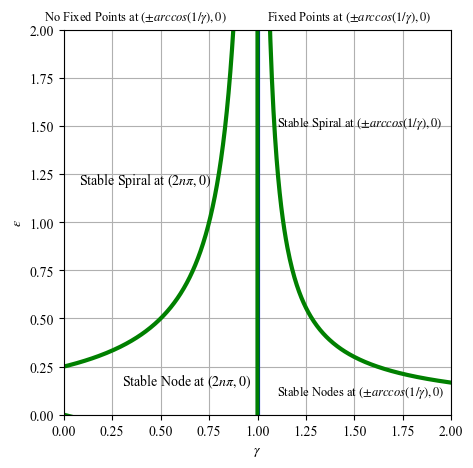

In [23]:
# determine (r,s) for the critical points 
dx = 500
xx = np.linspace(0,2,dx)
line = np.ones(dx)
xx_1 = np.linspace(0,2,dx)
f = 1 - 1/(4*xx_1)
g = ((4*xx_1**2-4)/xx_1)**(-1)

_, ax=plt.subplots(figsize=(5,5))
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.plot(line,xx,color='b',linewidth=3)
ax.plot(f,xx_1,color='g',linewidth=3)
ax.plot(xx_1,g,color='g',linewidth=3)
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$\epsilon$')
ax.text(1.05,2.05,'Fixed Points at $(\pm arccos(1/\gamma), 0)$',fontsize=9)
ax.text(-0.1,2.05,'No Fixed Points at $(\pm arccos(1/\gamma), 0)$',fontsize=9)
ax.text(0.3,0.15,'Stable Node at $(2n\pi, 0)$',fontsize=10)
ax.text(0.08,1.2,'Stable Spiral at $(2n\pi, 0)$',fontsize=10)
ax.text(1.1,1.5,'Stable Spiral at $(\pm arccos(1/\gamma), 0)$',fontsize=9)
ax.text(1.1,0.1,'Stable Nodes at $(\pm arccos(1/\gamma), 0)$',fontsize=9)
ax.grid()
plt.show()

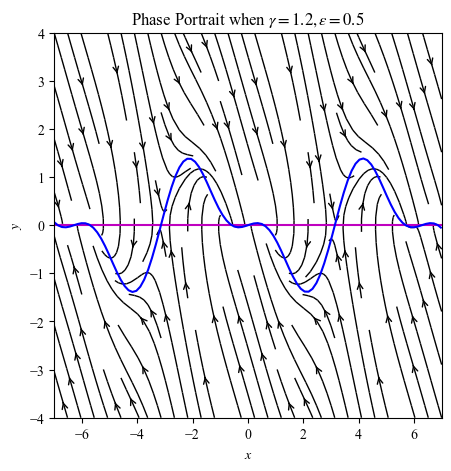

In [6]:
epsilon = 0.5
gamma = 1.2

f_x = lambda x,y: y
f_y = lambda x,y: (1/epsilon)*(-y-np.sin(x)+gamma*np.sin(x)*np.cos(x))

_, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Phase Portrait when $\gamma={gamma}, \epsilon={epsilon}$")
ax = PP_2d(-7,7,-4,4, f_x, f_y, ax)
ax = PP_nc(-7,7,-4,4, f_x, f_y, ax)


### Problem 2

#### Part (a)

Finding all fixed points:
<br>$\dot{\theta_1}=0\rightarrow sin(\theta_1) = Ksin(\theta_1 - \theta_2)$
<br>$\dot{\theta_1}=0\rightarrow sin(\theta_2) = Ksin(\theta_2 - \theta_1) \rightarrow sin(\theta_2) = -Ksin(\theta_1 - \theta_2)$
<br>$sin(\theta_1)=-sin(\theta_2)\rightarrow$ fixed points at $(n\pi, m\pi), n,m\in \mathbb{Z}$.
<br>Fixed points also at $(2(arctan(\sqrt{\frac{2K-1}{2K+1}})+n\pi),2(arctan(\sqrt{\frac{2K-1}{2K+1}})+m\pi))$.


In [7]:
# define f1, f2 and A
x,y,k = sp.symbols(r'\theta_1,\theta_2,K',nonnegative=True, real=True)

f1 = lambda x,y,k: k*sp.sin(x-y)-sp.sin(x)
f2 = lambda x,y,k: k*sp.sin(y-x)-sp.sin(y)

A = lambda x,y,k: sp.Matrix([f1(x,y,k),f2(x,y,k)]).jacobian([x,y]).applyfunc(sp.factor)
display(Latex(r'Jacobian of the Linearized System: ${}$'.format(sp.latex(A(x,y,k)))))
tau = A(x,y,k).trace()
delta = A(x,y,k).det()
display(Latex(r'$\tau={}$'.format(sp.latex(sp.simplify(tau)))))
display(Latex('$\Delta={}$'.format(sp.latex(sp.simplify(delta)))))
display(Latex(r'$\tau^2-4\Delta={}$'
              .format(sp.latex(sp.simplify(sp.Add(sp.Mul(tau,tau), sp.Mul(sp.Integer(-4), delta)))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Classifying Fixed Points:
<br>$(2n\pi,2m\pi)$: $\tau=2K-2, \Delta=-2K+1, \tau^2-4\Delta=4k^2$; if $K>0.5$, then $\Delta<0$, which makes it a saddle point; otherwise, $\tau<0$ and $ \tau^2-4\Delta=4k^2>0$, which makes it a stable node.
<br>
<br>$((2n+1)\pi,(2m+1)\pi)$: $\tau=2K+2, \Delta=2K+1, \tau^2-4\Delta=4k^2$; For all values of $K$, $\tau,\Delta,\tau^2-4\Delta>0$, which makes it an unstable node.
<br>
<br>$((2n+1)\pi,(2m)\pi)$ & $((2n)\pi,(2m+1)\pi)$: $\tau=-2K, \Delta=-1$; For all values of $K$, $\Delta<0 $, which makes it a saddle point.
<br>
<br>$(2(\pm arctan(\sqrt{\frac{2K-1}{2K+1}})+n\pi),2(\mp arctan(\sqrt{\frac{2K-1}{2K+1}})+m\pi))$: $0\leq\sqrt{\frac{2K-1}{2K+1}}\leq 1 \rightarrow 0\leq cos(2arctan(\sqrt{\frac{2K-1}{2K+1}}))\leq1$, this means that when they exist, $\tau \leq 2K-2, 0\leq \Delta \leq 1, (2K-2)^2 \leq \tau^2-4\Delta \leq (2K-2)^2-1$. For $K>0.5$, $\tau<0$ and $\Delta, \tau^2-4\Delta >0$, which means that for these fixed points, they are stable nodes.

#### Part (b)

The fixed points $(2(\pm arctan(\sqrt{\frac{2K-1}{2K+1}})+n\pi),2(\mp arctan(\sqrt{\frac{2K-1}{2K+1}})+m\pi))$ don't exist when $K<0.5$ because of the domain of the square root in the inverse tangent function. Once $K>0.5$, these fixed points exist. They exist close to the fixed points $(2n\pi, 2m\pi)$, where $n,m$ are integers, so it can be said that three fixed points generate around that point. $(2n\pi, 2m\pi)$ turns from a stable node to an unstable saddle point at $K=0.5$. At the same time, the two new fixed points are stable nodes, reflecting a stable exchange. Therefore, there is a supercritical pitchfork bifurcation that occurs at fixed points $(2n\pi, 2m\pi)$ with $K_c=0.5$.

#### Part (c)

If $V(\theta_1, \theta_2)=Kcos(\theta_1-\theta_2)-cos(\theta_1)-cos(\theta_2)$, then it can be shown that $\dot{\theta_1}=-\frac{\partial V}{\partial \theta_1} = Ksin(\theta_1-\theta_2)-sin(\theta_1)$ and that $\dot{\theta_2}=-\frac{\partial V}{\partial \theta_2} = -Ksin(\theta_1-\theta_2)-sin(\theta_2)=Ksin(\theta_2-\theta_1)-sin(\theta_2)$. This means that for this particular $V(\theta_1, \theta_2)$, it can show that the dynamical system is a gradient system.

#### Part (d)

From part (c), it was shown that the system can be written as the gradient of a potential function $V(\theta_1, \theta_2)$. According to Theorem 7.2.1, such systems cannot permit closed orbits to exist.

#### Part (e)

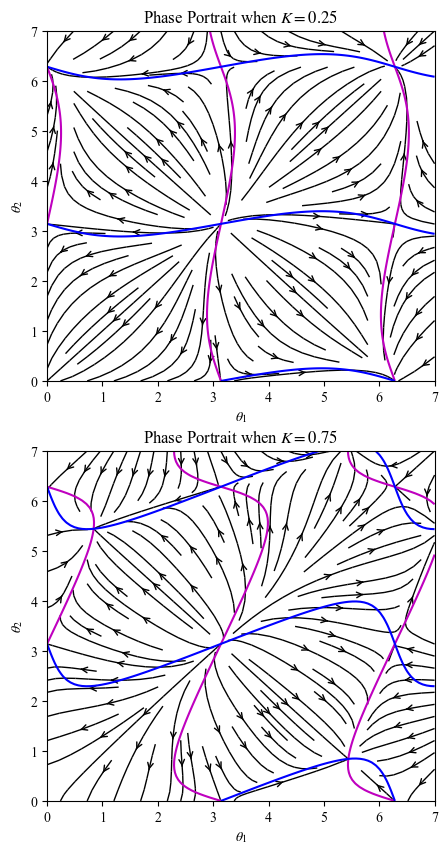

In [8]:
_, ax = plt.subplots(2,1,figsize=(5,10))
for i, k in enumerate([0.25, 0.75]):
    f_x = lambda x,y: k*np.sin(x-y)-np.sin(x)
    f_y = lambda x,y: k*np.sin(y-x)-np.sin(y)
    ax[i].set_xlabel(r"$\theta_1$")
    ax[i].set_ylabel(r"$\theta_2$")
    ax[i].set_title(f"Phase Portrait when $K={k}$")
    ax[i] = PP_2d(0,7,0,7, f_x, f_y, ax[i])
    ax[i] = PP_nc(0,7,0,7, f_x, f_y, ax[i])

### Problem 3

#### Part (a)

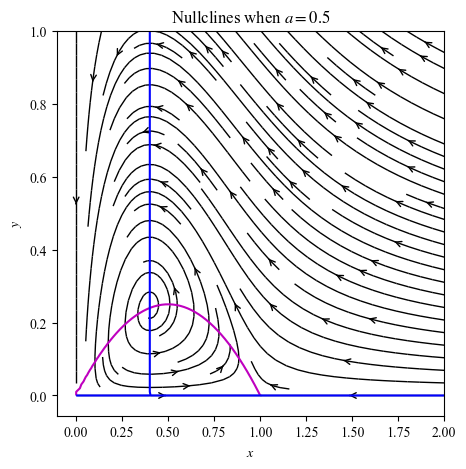

In [9]:
a=0.4

f_x = lambda x,y: x*(x*(1-x)-y)
f_y = lambda x,y: y*(x-a)

_, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Nullclines when $a=0.5$")
ax = PP_2d(0,2,0,1, f_x, f_y, ax)
ax = PP_nc(0,2,-0.00001,1, f_x, f_y, ax)

#### Part (b)

In [10]:
# define f1, f2 and A
x,y,a = sp.symbols('x,y,a',nonnegative=True)

f1 = lambda x,y: x*(x*(1-x)-y)
f2 = lambda x,y,a: y*(x-a)

A = lambda x,y,a: sp.Matrix([f1(x,y),f2(x,y,a)]).jacobian([x,y]).applyfunc(sp.factor)
print("Jacobian of the Linearized System")
A(x,y,a)

Jacobian of the Linearized System


Matrix([
[-3*x**2 + 2*x - y,     -x],
[                y, -a + x]])

In [11]:
# calculate fixed points (FPs) and their attributes

FPs = sp.solve((f1(x,y),f2(x,y,a)),x,y)
print('3 fixed points:')
[display(Latex('${}$'.format(sp.latex(FP)))) for FP in FPs];

A_FPs = [A(x,y,a).subs({x:FP[0],y:FP[1]}) for FP in FPs]

3 fixed points:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [12]:
for FP in FPs:
    display(Latex('Fixed Point ${}$'.format(sp.latex(sp.simplify(FP)))))
    tau = A(x,y,a).trace().subs({x:FP[0],y:FP[1]})
    delta = A(x,y,a).det().subs({x:FP[0],y:FP[1]})
    display(Latex(r'$\tau={}$'.format(sp.latex(sp.simplify(tau)))))
    display(Latex('$\Delta={}$'.format(sp.latex(sp.simplify(delta)))))
    display(Latex(r'$\tau^2-4\Delta={}$'
                  .format(sp.latex(sp.simplify(sp.Add(sp.Mul(tau,tau), sp.Mul(sp.Integer(-4), delta)))))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Classifying Fixed Points:
<br>$(0,0)$: Since $\Delta = 0$ for all values of $a$, this fixed point is a saddle point.
<br>$(1,0)$: Since $\tau\leq 0$ and $\tau^2-4\Delta\geq 0$ for all values of $a$, this fixed point is a stable node if $a>1$ and a spiral sink otherwise.
<br>$(a,a-a^2)$: For $a<0.5$, $\Delta>0$, $\tau>0$, and $\tau^2-4\Delta\ < 0$, which makes it an unstable spiral; for $0.5<a<1$, $\Delta>0$, and $\tau>0$, which makes it a stable spiral if $a<\sqrt{3}/2$ and a stable node otherwise; for $a>1$, $\Delta<0$, which makes it a saddle point. At $a=0.5$, $\tau=0$, which makes it a stable center.

#### Part (c)

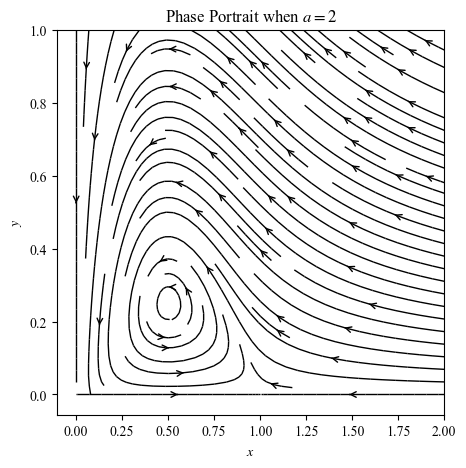

In [13]:
a=0.5

f_x = lambda x,y: x*(x*(1-x)-y)
f_y = lambda x,y: y*(x-a)

_, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Phase Portrait when $a=2$")
ax = PP_2d(0,2,0,1, f_x, f_y, ax, nx=300, ny=300)

The system tends to the stable node $(1,0)$. Since $y$ represents the predator population, this means that the system predicts the predators becoming extinct.

#### Part (d)

In [14]:
x,y,a = sp.symbols('x,y,a',nonnegative=True)
display(Latex(r'$Eigenvalues:{}$'.format(sp.latex(list(sp.simplify(A(x,y,a).eigenvals()).keys())))))

<IPython.core.display.Latex object>

For $a<\sqrt{3}/2$, the discriminant is negative at the fixed point $(a,a-a^2)$. This means that the real value of the eigenvalues are $Re(\lambda)=\frac{-3x^2+3x-y-a}{2}=\frac{a(1-2a)}{2}$. For $a<1/2, Re(\lambda)>0$ and the fixed point is an unstable spiral; for $1/2<a<\sqrt{3}/2, Re(\lambda)<0$ and the fixed point is a stable spiral. At $a=0.5, Re(\lambda)=0$ and the fixed point is a center. Based on the phase portrait below, visually there is Lyapunov stability around the fixed point, which indicates a limit cycle around the fixed point. The four quadrants created by the nullclines create indicate a circular trajectory due to how $\dot{x}$ and $\dot{y}$ change sign for the different quadrants. The fixed point is not an attractor, which means that trajectories will not tend to go towards it. Therefore, if a region constructed by two concentric circles at the fixed point, one just big enough to exclude the fixed point from the region and the other having a radius that suffiently divides itself somewhat equally among the four quadrants, will show that there is a close orbit inside the region via the Poincare-Bendixson theorem. The inner and outer parts of the region are the green circles in the phase diagram below.
<br>Since the spiral changes from unstable to stable with a center being generated at $a=0.5$, there is a supercritical Hopf bifurcation at $a=0.5$.

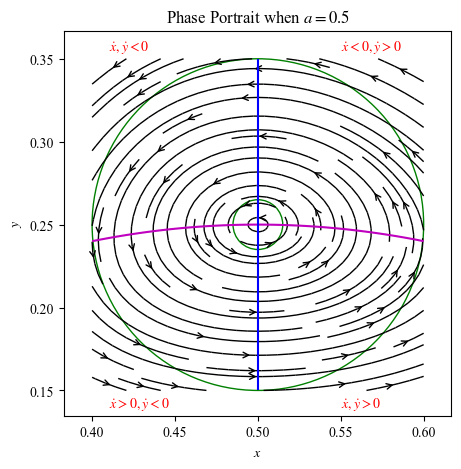

In [15]:
a=0.5

f_x = lambda x,y: x*(x*(1-x)-y)
f_y = lambda x,y: y*(x-a)
f_r = lambda x,y: (1/np.sqrt((x-a)**2+(y-a/2)**2))*((x-a)*f_x(x,y)+(y-a/2)*f_y(x,y))

_, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(f"Phase Portrait when $a={a}$")
ax = PP_2d(0.4,0.6,0.15,0.35, f_x, f_y, ax, nx=1000, ny=1000)
ax = PP_nc(0.4,0.6,0.15,0.35, f_x, f_y, ax, nx=1000, ny=1000)
ax.text(0.41,0.355,'$\dot{x},\dot{y}<0$',fontsize=10, color='r')
ax.text(0.41,0.14,'$\dot{x}>0,\dot{y}<0$',fontsize=10, color='r')
ax.text(0.55,0.14,'$\dot{x},\dot{y}>0$',fontsize=10, color='r')
ax.text(0.55,0.355,'$\dot{x}<0,\dot{y}>0$',fontsize=10, color='r')
_ = ax.add_patch(plt.Circle((a, a/2), 0.015, color='g', fill=False))
_ = ax.add_patch(plt.Circle((a, a/2), 0.1, color='g', fill=False))

#### Part (e)

In [16]:
x,y,a = sp.symbols('x,y,a',nonnegative=True)
display(Latex(r'Eigenvalues at $a=0.5$: ${}$'
              .format(sp.latex(list(
                  sp.simplify(
                      A(x,y,a).subs([(x,0.5), (y,0.25), (a,0.5)]).eigenvals()).keys()))
                      )))

<IPython.core.display.Latex object>

For supercritical Hopf bifurcations, the period of the stable cycle created can be approximated to be $T\approx\frac{2\pi}{|Im(\lambda)|}$ at $a=a_c$. This means that $T\approx\frac{2\pi}{0.35355}=17.8$.

#### Part (f)

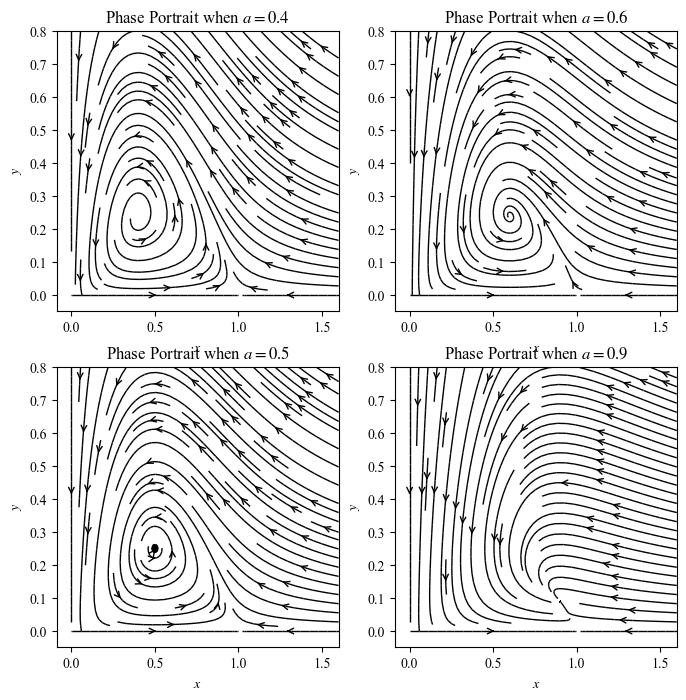

In [17]:
_, ax = plt.subplots(2,2,figsize=(8,8))
for i,a in enumerate([0.4,0.5,0.6,0.9]):
    f_x = lambda x,y: x*(x*(1-x)-y)
    f_y = lambda x,y: y*(x-a)
    ax[i%2][int(i/2)%2].set_xlabel("$x$")
    ax[i%2][int(i/2)%2].set_ylabel("$y$")
    ax[i%2][int(i/2)%2].set_title(f"Phase Portrait when $a={a}$")
    ax[i%2][int(i/2)%2] = PP_2d(0,1.6,0,0.8, f_x, f_y, 
                                ax[i%2][int(i/2)%2], nx=500, ny=500)

### Problem 4

#### Part (a)

In [18]:
def txyz_traj(f1,f2,f3,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[f1(x,y,z),f2(x,y,z),f3(x,y,z)]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

def txyz_LE(sigma,r,b,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[sigma*(y-x),r*x-y-x*z,x*y-b*z]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

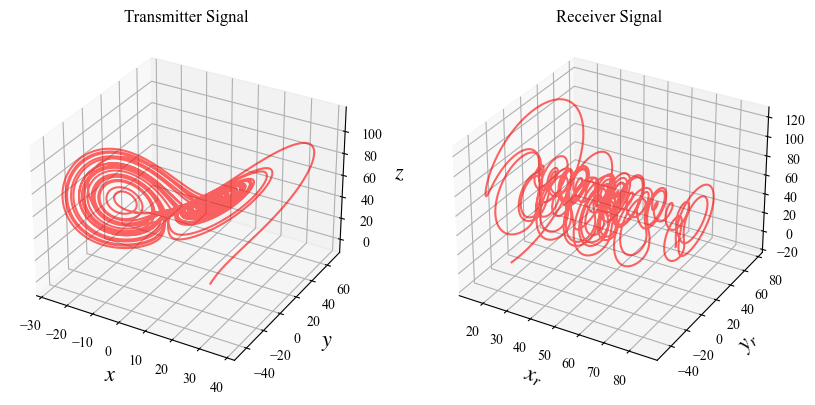

In [19]:
xyz_0 = [15,5,-10]
xyz_r0 = [15,-10,-20]
r, sigma, b = 60,10,8/3.0
T, dt = 25, 0.001
tr = np.arange(0,T+dt,dt)

def RHS(xyz_xyzr,t_):
        x,y,z,zr,yr,zr=xyz_xyzr
        return [sigma*(y-x),
                r*x-y-x*z,
                x*y-b*z,
                x,
                r*x-yr-x*zr,
                x*yr-b*zr]
xyzr = odeint(RHS,xyz_0+xyz_r0,tr)


t0=0; t0_=int(t0/dt)
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False

fig, ax = plt.subplots(1,2,figsize=(10,20),subplot_kw={'projection':'3d'})
ax[0].plot(xyzr[t0_:,0],xyzr[t0_:,1],xyzr[t0_:,2],'r',alpha=0.6)
ax[0].set_title("Transmitter Signal")
ax[0].set_xlabel('$x$', fontsize=16)
ax[0].set_ylabel('$y$', fontsize=16)
ax[0].set_zlabel('$z$', fontsize=16)
ax[1].plot(xyzr[t0_:,3],xyzr[t0_:,4],xyzr[t0_:,5],'r',alpha=0.6)
ax[1].set_title("Receiver Signal")
ax[1].set_xlabel('$x_r$', fontsize=16)
ax[1].set_ylabel('$y_r$', fontsize=16)
ax[1].set_zlabel('$z_r$', fontsize=16)
plt.show()

#### Part (b)

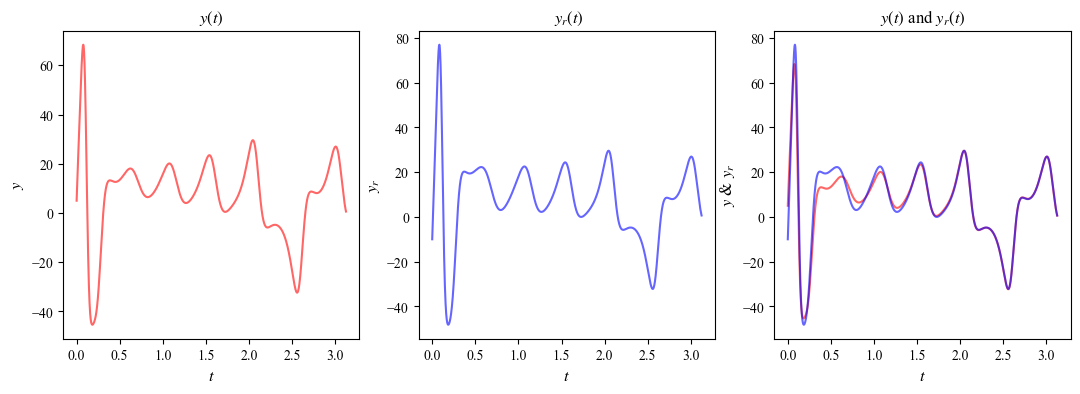

In [20]:
l = int(tr.size/8)

fig, ax = plt.subplots(1,3,figsize=(13,4))
ax[0].set_title("$y(t)$")
ax[0].plot(tr[:l],xyzr[:l,1],'r',alpha=0.6)
ax[0].set_xlabel('$t$', fontsize=12)
ax[0].set_ylabel('$y$', fontsize=12)
ax[1].set_title(" $y_r(t)$")
ax[1].plot(tr[:l],xyzr[:l,4],'b',alpha=0.6)
ax[1].set_xlabel('$t$', fontsize=12)
ax[1].set_ylabel('$y_r$', fontsize=12)
ax[2].set_title("$y(t)$ and $y_r(t)$")
ax[2].plot(tr[:l],xyzr[:l,1],'r',alpha=0.6)
ax[2].plot(tr[:l],xyzr[:l,4],'b',alpha=0.6)
ax[2].set_xlabel('$t$', fontsize=12)
ax[2].set_ylabel('$y$ & $y_r$', fontsize=12)
plt.show()

#### Part (c)

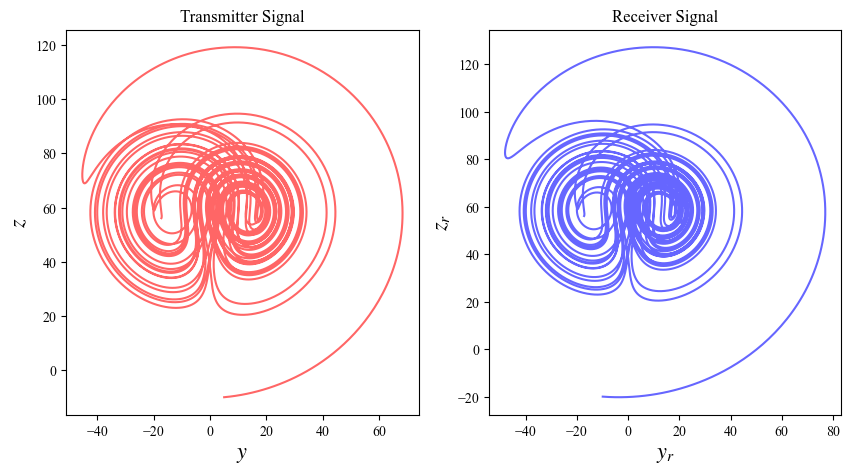

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(xyzr[t0_:,1],xyzr[t0_:,2],'r',alpha=0.6)
ax[0].set_title("Transmitter Signal")
ax[0].set_xlabel('$y$', fontsize=16)
ax[0].set_ylabel('$z$', fontsize=16)
ax[1].plot(xyzr[t0_:,4],xyzr[t0_:,5],'b',alpha=0.6)
ax[1].set_title("Receiver Signal")
ax[1].set_xlabel('$y_r$', fontsize=16)
ax[1].set_ylabel('$z_r$', fontsize=16)
plt.show()